In [1]:
import torch
from semilearn.core.utils import get_net_builder
from diffaug import Augmenter
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from semilearn.datasets.augmentation import RandAugment

import matplotlib.pyplot as plt

In [22]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform_strong = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=int(32 * (1 - 0.875)), padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    RandAugment(3, 5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform_val)
strong_aug_dataset = CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform_strong)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
augmenter = Augmenter(mean, std)

_net_builder = get_net_builder('wrn_28_2', False)
policy = _net_builder(num_classes=len(augmenter.operations))

In [6]:
model_dir = 'saved_models/D20L0.1/model_best.pth'
new_state_dict = dict()
state_dict = torch.load(model_dir, map_location='cpu')['policy']
for key, item in state_dict.items():
    if key.startswith('module'):
        new_key = '.'.join(key.split('.')[1:])
    else:
        new_key = key
    new_state_dict[new_key] = item
policy.load_state_dict(new_state_dict)

<All keys matched successfully>

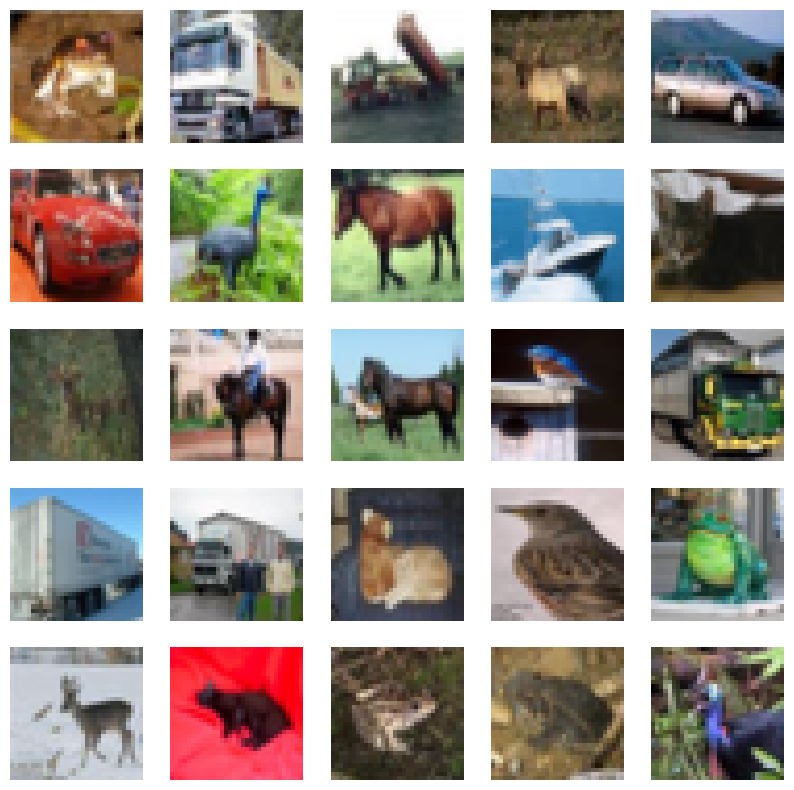

In [14]:
# grid show
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        img, _ = dataset[i * 5 + j]
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()

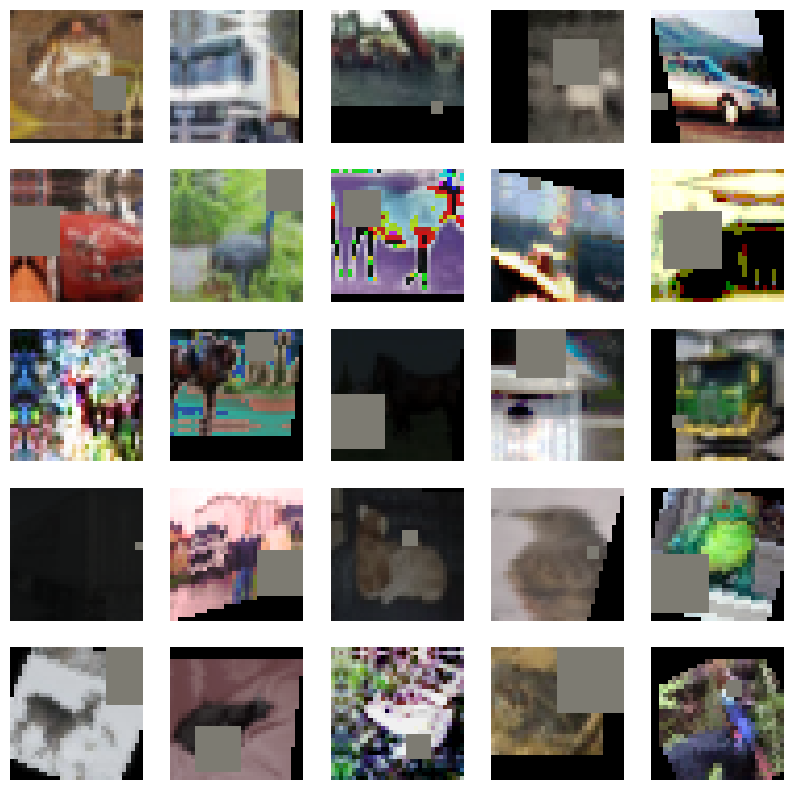

In [23]:
# grid show
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        img, _ = strong_aug_dataset[i * 5 + j]
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()

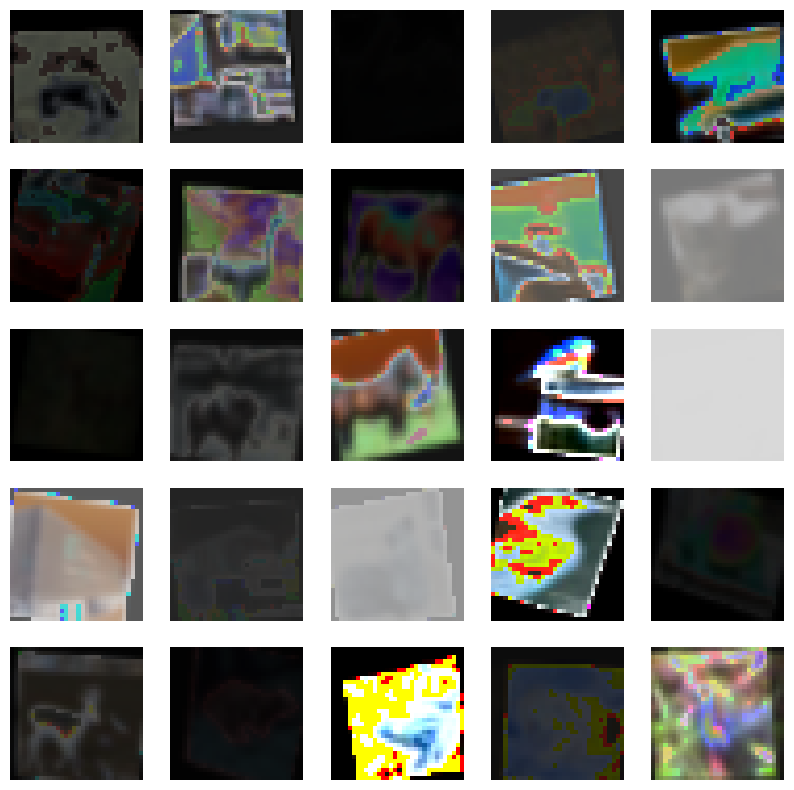

In [21]:
# grid show
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        img, _ = dataset[i * 5 + j]
        with torch.no_grad():
            mag = policy(img.unsqueeze(0))['logits']
            img = augmenter(img, mag).squeeze(0)
            img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()